In [1]:
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
from sklearn import preprocessing
np.random.seed(10)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import fileinput
from google.colab import files

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df=pd.read_csv("/content/TSLA.csv")

In [3]:
def augFeatures(df):
  df["Date"] = pd.to_datetime(df["Date"])
  df["year"] = df["Date"].dt.year
  df["month"] = df["Date"].dt.month
  df["date"] = df["Date"].dt.day
  df["day"] = df["Date"].dt.dayofweek
  df = df.drop(["Date"], axis=1)
  return df
  #separate the DateTime to year, month and day

In [4]:
def normalize(df):
  df_norm = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
  return df_norm
  #normalize the data

In [5]:
df_feat=augFeatures(df)
df_norm=normalize(df_feat)

In [6]:
def buildTrain(df, ref_day=5, predict_day=1):
    X_train, Y_train = [], []
    for i in range(df.shape[0]-predict_day-ref_day):
        X_train.append(np.array(df.iloc[i:i+ref_day]))
        Y_train.append(np.array(df.iloc[i+ref_day:i+ref_day+predict_day]["Close"]))
    return np.array(X_train), np.array(Y_train)
    #seperate the data to x_train and y_train
    #the main goal is to predict the  day after the fifth-day price

In [7]:
def shuffle(X,Y):
  np.random.seed(10)
  randomList = np.arange(X.shape[0])
  np.random.shuffle(randomList)
  return X[randomList], Y[randomList]
#make a random list 

In [8]:
def splitData(X,Y,rate):
  X_train = X[:int(X.shape[0]*rate)]
  Y_train = Y[:int(Y.shape[0]*rate)]
  X_val = X[int(X.shape[0]*rate):]
  Y_val = Y[int(Y.shape[0]*rate):]
  return X_train, Y_train, X_val, Y_val

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [10]:
X_train, Y_train = buildTrain(df_norm, 5, 1)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.9)

In [11]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 50)             12200     
_________________________________________________________________
dropout (Dropout)            (None, 5, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [12]:
train_history=model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs = 100, batch_size = 128, verbose=2)

Epoch 1/100
17/17 - 1s - loss: 0.0144 - val_loss: 0.0057
Epoch 2/100
17/17 - 0s - loss: 0.0017 - val_loss: 0.0044
Epoch 3/100
17/17 - 0s - loss: 0.0010 - val_loss: 0.0043
Epoch 4/100
17/17 - 0s - loss: 7.3923e-04 - val_loss: 0.0028
Epoch 5/100
17/17 - 0s - loss: 6.8848e-04 - val_loss: 0.0020
Epoch 6/100
17/17 - 0s - loss: 5.9246e-04 - val_loss: 0.0016
Epoch 7/100
17/17 - 0s - loss: 6.0875e-04 - val_loss: 0.0013
Epoch 8/100
17/17 - 0s - loss: 5.2192e-04 - val_loss: 0.0011
Epoch 9/100
17/17 - 0s - loss: 5.0921e-04 - val_loss: 9.5403e-04
Epoch 10/100
17/17 - 0s - loss: 5.1472e-04 - val_loss: 9.6494e-04
Epoch 11/100
17/17 - 0s - loss: 4.9596e-04 - val_loss: 9.4623e-04
Epoch 12/100
17/17 - 0s - loss: 5.1851e-04 - val_loss: 0.0011
Epoch 13/100
17/17 - 0s - loss: 5.0193e-04 - val_loss: 0.0011
Epoch 14/100
17/17 - 0s - loss: 5.2178e-04 - val_loss: 0.0011
Epoch 15/100
17/17 - 0s - loss: 4.8917e-04 - val_loss: 0.0010
Epoch 16/100
17/17 - 0s - loss: 4.7687e-04 - val_loss: 9.8012e-04
Epoch 17/100


In [13]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()

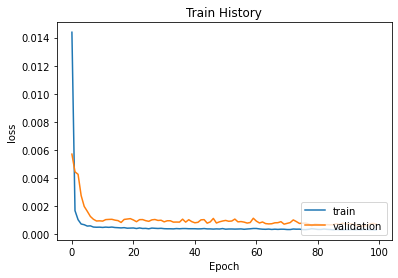

In [14]:
show_train_history(train_history,'loss','val_loss')

In [15]:
model.evaluate(X_val,Y_val)


8/8 [==============================] - 0s 3ms/step - loss: 7.2591e-04


0.000725910475011915

In [16]:
predict_y = model.predict(X_val)

In [17]:
def denormalize(train):
  denorm = train.apply(lambda x: x*(np.max(df["Close"])-np.min(df["Close"]))+np.mean(df["Close"]))
  return denorm

Y_val = pd.DataFrame(Y_val)
Y_val = denormalize(Y_val)
predict_y = pd.DataFrame(predict_y)
predict_y = denormalize(predict_y)

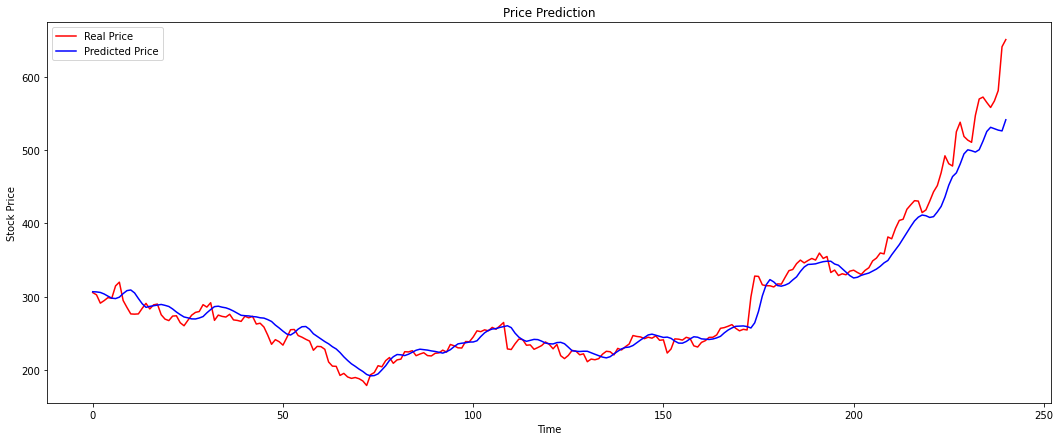

In [22]:
import matplotlib.pyplot as plt 
plt.figure(figsize = (18,7))
plt.plot(Y_val, color = 'red', label = 'Real Price')  # red line is real CLOSE price
plt.plot(predict_y, color = 'blue', label = 'Predicted Price')  #blue line is predicted price
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [23]:
A = Y_val
B = predict_y
retsA=A-A.shift(1)
retsB=B-B.shift(1)
retsA = np.array(retsA)
retsB = np.array(retsB)
count = 0
for i in range(125):
    if retsA[i+1]>retsA[i] and retsB[i+1]>retsB[i]:
        count = count+1
    elif retsA[i+1]<retsA[i] and retsB[i+1]<retsB[i]:
        count = count+1
    else:
        count = count
accuracy = count / 125

In [24]:
print(accuracy)
print(count)

0.4
50
